In [1]:
# import os
import os.path as op
from pathlib import Path
import numpy as np
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import mne

from scipy import stats
from mne.stats import permutation_cluster_1samp_test

from library import helpers, config


In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def get_evokeds_dict(epo_part, sub_list,  plt_dict, data_type="difference"):
    evokeds = defaultdict(list)
    for sub in sub_list: 
        if data_type not in ["difference", "collapsed"]:
            raise ValueError(f"Invalid data type '{data_type}'. Has to be either 'difference' or 'collapsed'.")
        subID = 'VME_S%02d' % sub
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                        data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        epos.pick_channels(config.chans_CDA_dict['Left'])
        epos.crop(plt_dict[epo_part]['xmin'], plt_dict[epo_part]['xmax'])
        event_dict = helpers.get_event_dict(epos.event_id)
        for load in ['LoadLow', 'LoadHigh']:
            evoked_load = epos[event_dict[load]].copy().average()   
            evokeds[load].append(evoked_load)
            for ecc in ['EccS', 'EccM', 'EccL']:
                if load == 'LoadLow':  # we don't want to do this twice
                    evoked_ecc = epos[event_dict[ecc]].copy().average()  
                    evokeds[ecc].append(evoked_ecc)
                # Interaction:
                evoked_interac = epos[event_dict[load]][event_dict[ecc]].copy()
                evoked_interac = evoked_interac.average()
                evokeds[load+ecc].append(evoked_interac)
        evokeds['all'].append(epos.copy().average())
    return(evokeds)



def plot_main_cda(ax, evokeds):
    # Plot main curve CDA:
    label_dict = dict()
    label_dict['CDA: Contra - Ipsi'] = evokeds['all']

    mne.viz.plot_compare_evokeds(label_dict, 
                                combine='mean', 
                                #colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )

    ax.legend(loc=1, prop={'size': 9})
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.set_aspect(0.25)
    ax.set_title('')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)
    plt.xticks(fontsize=9)


def run_cbp_test(data, n_perm=1000, p_initial=0.05, p_thresh=0.05, tail=0.):
    """Run a cluster-based permutation test: paired t-test. 
    
    Parameters
    ----------
    data : ndarray, shape (n_observations, times)
        2d array with difference between conditions (n_observations x timepoints)
    n_perm : int
        Number of permutations, default: 1000
    p_initial : int
        Initial threshold (1st round of cbp test), default: 0.05
    p_thresh : int
        Familywise p value (2nd round of cbp test), default: 0.05
    tail : int
        0: two-sided test (default); -1: left-sided; 1: right-sided

    Returns
    -------
    T_obs : array, shape (n_tests,)
        T-statistic observed for all variables.
    clusters : list
        list of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        P-value for each cluster.

    Notes
    -------
    For details check documentation of `mne.stats.permutation_cluster_1samp_test`.
    """
    # number of permutations to run
    n_permutations = n_perm 
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = None
    tail = tail  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.n_jobs,
        verbose=True,
        tail=tail,
        step_down_p=0.05,
        adjacency=adjacency,
        n_permutations=n_permutations,
        seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)

def find_largest_cluster_times(clusters, times): 
    #TODO: write DOCSTR or remove
    cl_lengths = [c[0].stop - c[0].start for c in clusters]
    idx_max_length = np.argmax(cl_lengths)
    return (times[clusters[idx_max_length]], idx_max_length)


def plot_cbp_result_cda(ax, T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full):
    """Plot the results of the CBP test by plotting the T values over time,
    highlighting significant clusters.

    Paramteters
    -------
    ax : Axes instance
        Axes object to plot into.
    clusters : list
        Output of `run_cbp_test`.
        List of tuple of ndarray, where each ndarray contains the indices of
        locations that together form the given cluster along the given dimension.
    cluster_p_values : array
        Output of `run_cbp_test`.
        P-value for each cluster.
    p_thresh : int
        Familywise p value (2nd round of cbp test) used in the underlying CBP test
    times_cbp : array, shape (srate * duration retention interval,)
        Sample times.
    times_full : array, shape (srate * duration full trial,)
        Sample times.
    """
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(times_cbp[c[0]], times_cbp[c[-1]],
                            color='r', alpha=0.3)
    ax.plot(times_cbp, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
           ylim=y_max,
           xlim=times_full[np.array([0,-1])])
    fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    # ax.set_aspect('auto', adjustable='datalim')
    # ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_effect_load(evokeds, ax, sign_cluster=None):
    """Plot the main effect of Memory Load on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.
    """
    conds = ['LoadLow', 'LoadHigh']
    plt_names = ['2', '4']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict, 
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )
    # Fake legend:
    custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['LoadLow'], lw=2),
                    matplotlib.lines.Line2D([0], [0], color=config.colors['LoadHigh'], lw=2)]
    ax.legend(handles=custom_lines,
              #labels=conds,
              loc=1, 
              prop={'size': config.plt_label_size},
              title='Size Memory Array',
              labels=['2 items', '4 items'])
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color='red', alpha=0.1)
    ax.set_aspect(0.25)
    ax.set_title('')
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    plt.xticks(fontsize=config.plt_label_size)
    plt.yticks(fontsize=config.plt_label_size)


def plot_main_effect_ecc(evokeds, ax, sign_cluster=None):
    """Plot the main effect of Eccentricity on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.
    """
    # Main Effect Ecc:
    conds = ['EccS', 'EccM', 'EccL']
    plt_names = ['4°', '9°', '14°']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict, 
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=True,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False
                                )
    ax.legend(loc=1, prop={'size': config.plt_label_size}, 
              title='Eccentricity', ncol=3)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color='red', alpha=0.1)
    ax.set_aspect(0.25)
    ax.set_title('')
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    plt.xticks(fontsize=config.plt_label_size)
    plt.yticks(fontsize=config.plt_label_size)



def plot_interaction_eff(evokeds, axs):
    """Plot the effect of Memory Load on the lateralized ERP split up by Eccentricity condition.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    """
    for ecc, tt, idx, leg in zip(['EccS', 'EccM', 'EccL'], 
                            ['Ecc = 4°', 'Ecc = 9°', 'Ecc = 14°'], 
                            [0, 1, 2], 
                            [1, False, False]):
        conds = ['LoadLow', 'LoadHigh']
        plt_names = ['Load Low', 'Load High']
        #data = [evo.crop(plt_dict[epo_part][xmin], plt_dict[epo_part][xmin]) for evo in evokeds]
        plt_dict = {nn: evokeds[k + ecc] for k, nn in zip(conds, plt_names)}
        res = mne.viz.plot_compare_evokeds(plt_dict, 
                                    combine='mean', 
                                    ci=True,
                                    axes=axs[idx],
                                    legend=leg,
                                    colors = {k: config.colors[k] for k in plt_dict.keys()},
                                    vlines=[0, 0.2, 2.2],
                                    ylim=dict(eeg=[-1.5,1.5]),
                                    title=None, 
                                    show = False, 
                                    truncate_yaxis=False, 
                                    truncate_xaxis=False
                                    )
    #axs[1].yaxis.set_visible(False)
    axs[1].set_yticklabels([])
    axs[2].set_yticklabels([])
    axs[1].yaxis.label.set_visible(False)
    axs[2].yaxis.label.set_visible(False)
    axs[0].xaxis.label.set_visible(False)
    axs[2].xaxis.label.set_visible(False)
    axs[0].legend(loc=1, prop={'size': 6})

    for axx, ecc in zip(axs, ['4', '9', '14']):
        #axx.set_aspect('auto')
        axx.axvspan(0, 0.2, color='grey', alpha=0.3)
        axx.axvspan(2.2, 2.3, color='grey', alpha=0.3)
        axx.set_aspect(0.33)
        axx.set_title('')
        at = AnchoredText(" Ecc.: " + ecc + "° ",
                            loc='lower left', prop=dict(size=9), frameon=True,
                            bbox_to_anchor=(-0.01, 0.97),
                            bbox_transform=axx.transAxes)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axx.add_artist(at)

        
def allsubjects_mean_amp_to_df(sub_list, epo_part, channels, t_min, t_max, component_name, data_type="difference"):
    mean_amp_df = pd.DataFrame()
    for sub in sub_list:
        subID = 'VME_S%02d' % sub
        print(F"Reading {subID}...")
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos_ = mne.read_epochs(fname, verbose=False)
        df_ = mean_amp_to_df(epos_, subID, channels, t_min, t_max, component_name)
        mean_amp_df = mean_amp_df.append(df_)
    
    return mean_amp_df
        
        
        
# TODO: docu
def mean_amp_to_df(epos, subID, channels, t_min, t_max, component_name):
    """Takes the Epochs of one subject, calculates the mean amplitude in a given ROI and time window per 
    trial, and returns a data frame."    
    """
    
    epos.pick_channels(channels)
    epos.crop(t_min, t_max)
    
    # Keep volatge in V for backwards compatibility:
    scalings = {'eeg': 1}
    df = epos.to_data_frame(scalings=scalings)

    df['signal_roi'] = df[channels].mean(axis=1)
    dict_load = {v: k for k in config.event_dict for v in config.event_dict[k] if "Load" in k}
    dict_ecc = {v: k for k in config.event_dict for v in config.event_dict[k] if "Ecc" in k}
    df['c_Ecc'] = df['condition'].replace(dict_ecc)
    df['c_StimN'] = df['condition'].replace(dict_load)
    df2 = df.groupby(['epoch', 'c_Ecc', 'c_StimN']).mean().reset_index()
    df2["trial_num"] = df2["epoch"] + 1
    df2["subID"] = subID
    colname = f"{component_name.lower()}_mean_amp"
    df2[colname] = df2["signal_roi"]
    df3 = df2[["subID", "c_StimN", "c_Ecc",  colname, "trial_num"]]
    return df3

In [4]:

# define dict used for plotting of different epo parts:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0, 
      'xmin': -0.2, 
      'xmax': 2.3}
plt_dict['stimon'] = pp


In [5]:

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)

epo_part = 'stimon'

# get the evokeds: 
evokeds = get_evokeds_dict(epo_part, sub_list, plt_dict, data_type="difference")


combining channels using "mean"


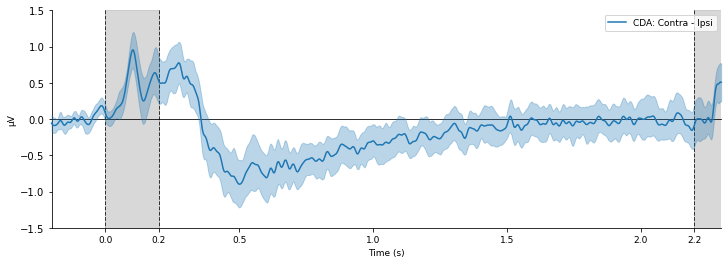

In [40]:

# Plot main CDA wave:
fig, ax = plt.subplots(1,1,figsize=(12,4))
plot_main_cda(ax, evokeds)
plt.show()

stat_fun(H1): min=-5.470331 max=5.222653
Running initial clustering
Found 5 clusters
Permuting 999 times...


/tmp/ipykernel_119031/3250778444.py:102: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  cluster_stats = permutation_cluster_1samp_test(


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
combining channels using "mean"


/tmp/ipykernel_119031/3250778444.py:157: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=0.5)


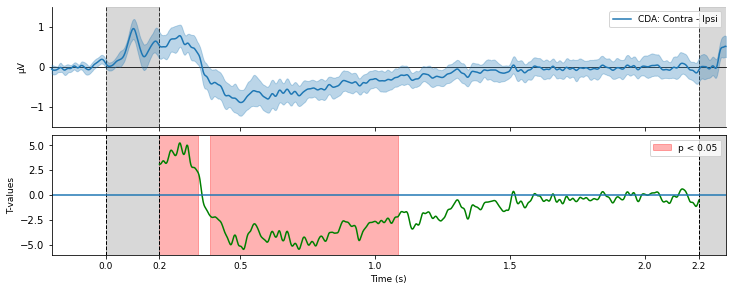

In [41]:
## Run cb-perm test to find intervall of interest:

# get data - cropped to retention interval:
times_full = evokeds['all'][0].times
c_list = [evo.copy().crop(config.times_dict['stim_dur'],
                          config.times_dict['stim_dur'] + config.times_dict['retention_dur'])
          for evo in evokeds['all']]
data = np.array([np.mean(c.data, axis=0) for c in c_list])
times_cbp = c_list[0].times
p_thresh = 0.05
# run cbp test:
T_obs, clusters, cluster_p_values = run_cbp_test(data)

#TODO: check if the following line can be removed or replace by extraction of sign cluster times
# get times of strongest cluster:
# cluster_times, _ = find_largest_cluster_times(clusters, times_cbp)

# Plot the result:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True, constrained_layout=True)
plot_main_cda(axes[0], evokeds)
axes[0].xaxis.label.set_visible(False)
plot_cbp_result_cda(axes[1], T_obs, clusters, cluster_p_values, p_thresh, times_cbp, times_full)

# Save it: 
fpath = op.join(config.paths['plots'], 'CDA', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'ERP_lateralized_sign_clusters_cbp.png')
fig.savefig(fname, bbox_inches="tight")


We see two significant clusters: 
- 1 very early in the trial --> this is the PNP
- 1 a bit later --> this is the CDA

In [42]:
# get CDA times:
sign_cluster_idxs = np.where(cluster_p_values < p_thresh)[0]
# pick second sign. cluster
cda_times = times_cbp[clusters[sign_cluster_idxs[1]]]
cda_info_dict = {'cda_sign_cluster_t_start': cda_times[0],
                 'cda_sign_cluster_t_end': cda_times[-1],
                 'cda_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[1]]}

# Extract vars:
for key in cda_info_dict:
    helpers.extract_var(key, cda_info_dict[key], exp_format='.3f')

# get PNP times:
# pick first  sign. cluster
pnp_times = times_cbp[clusters[sign_cluster_idxs[0]]]
pnp_info_dict = {'pnp_sign_cluster_t_start': pnp_times[0],
                 'pnp_sign_cluster_t_end': pnp_times[-1],
                 'pnp_sign_cluster_pval': cluster_p_values[sign_cluster_idxs[0]]}

# Extract vars:
for key in pnp_info_dict:
    helpers.extract_var(key, pnp_info_dict[key], exp_format='.3f')
    

### Save the mean amplitude data to CSV
To run statistics in R, we export mean amplitudes to CSV.
We do this twice:
1. for a fixed time window that we take from the literature (CDA: [Hakim et al., 2019](https://doi.org/10.1177/0956797619830384); PNP: [Papaioannou & Luck, 2020](https://doi.org/10.1111/psyp.13532)).
2. for a time window that we get in a data-driven fasion by running an agnostic cluster-based permutation test, identifying a time window where the difference wave is significantly different from 0 (across all conditions).

In [ ]:
# CDA
## fixed time window:
dff = allsubjects_mean_amp_to_df(sub_list, 'stimon', config.chans_CDA_dict['Left'], 0.45, 1.45, 'CDA')
fpath = op.join(config.paths['04_evokeds-CDA'], 'summaries', 'fixed_times')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(sub_list, 'stimon', config.chans_CDA_dict['Left'],
                                 cda_times[0], cda_times[-1], 'CDA')
dff.groupby('c_StimN').mean() 
fpath = op.join(config.paths['04_evokeds-CDA'], 'summaries', 'cluster_times')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_CDA.csv")
dff.to_csv(fname, float_format="%.15f")

# PNP
## fixed time window:
dff = allsubjects_mean_amp_to_df(sub_list, 'stimon', config.chans_CDA_dict['Left'], 0.300, 0.444, 'PNP')
fpath = op.join(config.paths['04_evokeds-PNP'], 'summaries', 'fixed_times')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")

## data driven window
dff = allsubjects_mean_amp_to_df(sub_list, 'stimon', config.chans_CDA_dict['Left'],
                                 pnp_times[0], pnp_times[-1], 'PNP')
fpath = op.join(config.paths['04_evokeds-PNP'], 'summaries', 'cluster_times')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-mean_amp_PNP.csv")
dff.to_csv(fname, float_format="%.15f")


combining channels using "mean"
combining channels using "mean"


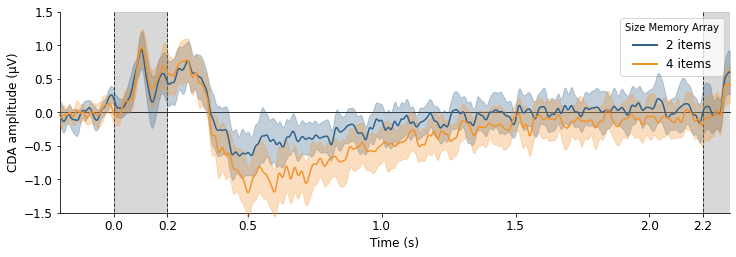

In [43]:
# Plot main effect load:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ha = plot_main_effect_load(evokeds, ax)
plt.show()

combining channels using "mean"
combining channels using "mean"


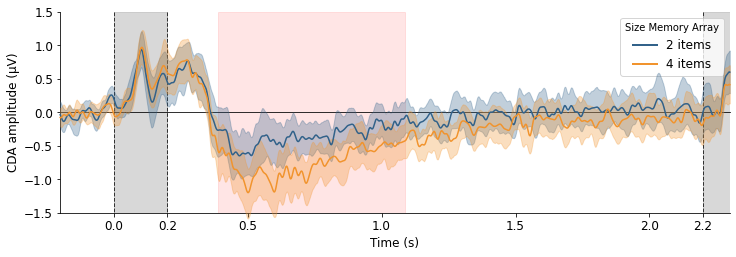

In [44]:
#And here overlaid with the region of the sign. cluster identified earlier:
fig, ax = plt.subplots(1,1,figsize=(12,4))
plot_main_effect_load(evokeds, ax, sign_cluster=(cda_times[0], cda_times[-1]))

# Save it: 
# fpath = op.join(config.path_plots, 'CDA', epo_part)
# helpers.chkmk_dir(fpath)
# fname = op.join(fpath, 'mainEff_load.svg')
#fig.savefig(fname, bbox_inches="tight")

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


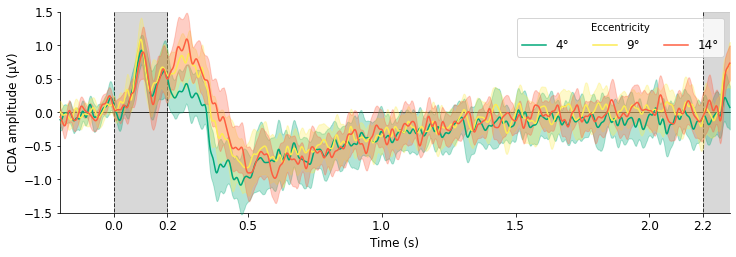

In [45]:
# plot main effect ecc: 
fig, ax = plt.subplots(1,1,figsize=(12,4))

plot_main_effect_ecc(evokeds, ax)

# Save it: 
# fpath = op.join(config.path_plots, 'CDA', epo_part)
# helpers.chkmk_dir(fpath)
# fname = op.join(fpath, 'mainEff_ecc.svg')
# fig.savefig(fname, bbox_inches="tight")

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


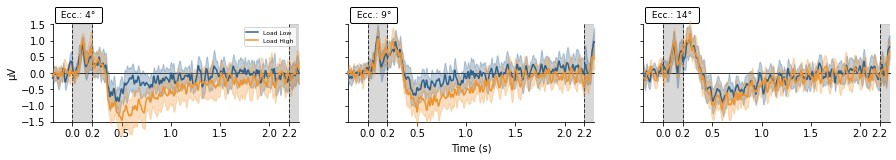

In [46]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
plot_interaction_eff(evokeds, axs)

# Save it:
# fpath = op.join(config.path_plots, 'CDA', epo_part)
# helpers.chkmk_dir(fpath)
# fname = op.join(fpath, 'interaction_loadxecc.svg')
# fig.savefig(fname, bbox_inches="tight")